In [1]:
import os
import glob
import itertools
import json
import importlib

import pingouin as pg
import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

In [2]:
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.extraction.rois as rutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.objects.selectivity as sel

In [4]:
# def assign_sparseness(df):
#     mt = sparseness(df['response'].values)
#     return pd.Series(mt, name=df['cell'].unique()[0])

# def sparseness(responses):
#     '''
#     num = 1 - [ (sum(Ri/n)**2) / sum( ((Ri**2)/n) ) ] 
#     denom = [1 - (1/n)]
#     from:  Zoccolan et al, 2007; Rolls & Tovee, 1995; Vinje and Gallant, 2000; Olshausen and Field, 2004.
#     '''
#     n = float(len(responses))
#     num = 1. - ( (sum(responses/n)**2) / sum( (responses**2)/n ) )
#     denom = (1. - (1./n))
    
#     return (num/denom)

def calculate_metrics(x0, sdf, images='all', iternum=None):

    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    rdf['size'] = [sdf['size'][c] for c in rdf['config']]
    rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
    if images=='all':
        resp_ = rdf[rdf['morphlevel']!=-1].copy()
    elif images=='anchors':
        resp_ = rdf[rdf['morphlevel'].isin([0, 106])].copy()
    else:
        resp_ = rdf.copy()
    sparse_ixs = resp_[['cell', 'response']].groupby(['cell'])\
                    .apply(sel.assign_sparseness).rename(columns={0:'sparseness'})
    #Luminance check
    #if -1 in rdf['morphlevel'].values:
    lum_ccs = rdf.groupby(['cell']).apply(sel.get_lum_corr)
    lum_ccs.index = lum_ccs.index.droplevel()

    size_sel = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                    .apply(sel.assign_lum_ix, at_best_other=True)\
                    .rename(columns={0:'size_ix'})
    lum_sel = rdf[rdf['morphlevel']==-1].groupby(['cell'])\
                    .apply(sel.assign_lum_ix, at_best_other=True)\
                    .rename(columns={0:'lum_ix'})
    # Combine
    ixs_ = pd.concat([sparse_ixs, size_sel, lum_sel, lum_ccs], axis=1)
    ixs_['cell'] = ixs_.index
    if iternum is not None:
        ixs_['iteration'] = iternum
    return ixs_


In [116]:
va='V1'
dk = '20191006_JC110_fov1'
x0=NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()


In [119]:
x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)

,cell,config,response
0,4,config001,-0.002374
1,4,config002,0.003447
2,4,config003,0.009664
3,4,config004,0.004954
4,4,config005,0.025548
...,...,...,...
4295,390,config046,0.016062
4296,390,config047,0.024426
4297,390,config048,0.023214
4298,390,config049,0.020091


In [122]:
rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf['size'] = [sdf['size'][c] for c in rdf['config']]
rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]

resp_ = rdf[rdf['morphlevel'].isin([0, 106])].copy()
responses = resp_[resp_['cell']==rois_[0]].copy()

n = float(len(responses))
print(n)


10.0


# Aggregate

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

In [6]:
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                                  create_new=False,
                                                  return_cells=True, return_missing=True)
all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
             datakey  cell
visual_area               
Li              3661  3661
Lm              4144  4144
V1              4028  4028


In [7]:
experiment='blobs'
traceid = 'traces001'

response_type='dff'
trial_epoch = 'stimulus'
responsive_test='ROC'
responsive_thr=0.05

assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)
# Get unique dkeys and count
n_responsive, blobs_dkeys = aggr.count_n_responsive(NDATA0, u_dkeys=None)
n_total = aggr.count_n_total(assigned_cells, blobs_dkeys)
u_dkeys = blobs_dkeys

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15.0 0.0], y: [-5.0 0.0]
... not in exp: 20191105_JC117_fov1
... not in exp: 20191105_JC117_fov1
[V1] Animalid does not exist: JC078 


In [8]:
s_=[]
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    sdf = aggr.get_stimuli(dk, experiment, match_names=True)
    if 'aspect' in sdf.columns:
        sdf = sdf.drop(columns=['aspect'])
    if sdf.shape[0]<45:
        continue
    sdf['visual_area'] = va
    sdf['datakey'] = dk
    # print(dk, sdf.shape)
    s_.append(sdf)
SDF = pd.concat(s_, axis=0)

In [9]:
NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys])

In [21]:
exclude=['20190314_JC070_fov1'] # wrong configs
images='all'
remove_offset = False
d_=[]
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
    if dk in exclude:
        continue
    if dk not in SDF['datakey'].values:
        continue
    #print(dk)
    sdf = aggr.get_stimuli(dk, experiment=experiment, match_names=True)
    if len(sdf[sdf['morphlevel']==-1])==0:
        continue
    configs = sdf.index.tolist()
    #print(len(configs))
    if remove_offset:
        x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
    
    #x0['response'] = x0['response'].abs()
    tmpdf = calculate_metrics(x0[x0.config.isin(configs)], sdf, 
                                           images=images)
    tmpdf['visual_area'] = va
    tmpdf['datakey'] = dk
    tmpdf['n_cells'] = len(x0['cell'].unique())
    d_.append(tmpdf)

ixdf = pd.concat(d_, axis=0).reset_index()

In [22]:
ixdf[ixdf['sparseness']<0]

,index,sparseness,size_ix,lum_ix,lum_cc,lum_p,cell,visual_area,datakey,n_cells


In [23]:
min_ncells=10

xdf = ixdf[(ixdf['sparseness']<=1) & (ixdf['sparseness']>=0)
          & (ixdf['n_cells']>=min_ncells)].copy()
print(ixdf.shape, xdf.shape)

(2025, 10) (1960, 10)


In [24]:

means_by_fov = xdf.dropna().groupby(['visual_area', 'datakey']).median().reset_index()
ncells_by_fov = xdf.dropna().groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
xdf_means = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

# Output plotting

In [25]:
aggregate_dir= '/n/coxfs01/julianarhee/aggregate-visual-areas'
FIGDIR = os.path.join(aggregate_dir, 'FIGURES')

bw_area_colors={'V1': [0.7]*3, 'Lm': [0.7]*3, 'Li': [0.7]*3}

fontsize=6
lw=0.25

In [26]:
xdf.head()

,index,sparseness,size_ix,lum_ix,lum_cc,lum_p,cell,visual_area,datakey,n_cells
0,76,0.361818,0.773567,0.854473,0.932923,0.020643,76,Li,20190422_JC076_fov1,29
1,80,0.053774,0.407174,0.225602,0.214472,0.729033,80,Li,20190422_JC076_fov1,29
2,81,0.112331,0.547868,0.551630,-0.571501,0.314164,81,Li,20190422_JC076_fov1,29
3,119,0.395522,0.638608,1.041157,0.508628,0.381516,119,Li,20190422_JC076_fov1,29
4,135,0.350336,0.490320,0.786332,0.499378,0.391689,135,Li,20190422_JC076_fov1,29


In [19]:
data_id = '%s|%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
data_id

'traces001|dff_ROC-0.05'

[mean]:
  visual_area  sparseness  sparseness_std
0          Li    0.388436        0.242857
1          Lm    0.449735        0.245792
2          V1    0.396830        0.234907


<IPython.core.display.Javascript object>


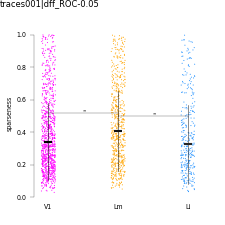

In [27]:
%matplotlib notebook
plot_cells=True
multi_comp_test='fdr_bh' #'fdr_bh'
bw = True

curr_colors = bw_area_colors if bw else area_colors
plot_params=['sparseness'] #, 'lum_ix']
plot_str = 'byCELL' if plot_cells else 'byFOV'
plotdf = xdf.dropna().copy() if plot_cells else mean_indices.copy()
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params)

fig, ax = pl.subplots( figsize=(3,3))

y_loc=0.5 #1.01
offset=0.01
for ai, metric in enumerate(plot_params):
    sns.stripplot(x='visual_area', y=metric, hue='visual_area', data=plotdf, 
                palette=area_colors, order=visual_areas, size=1, ax=ax, zorder=-10000)
    sns.pointplot(x='visual_area', y=metric, hue='visual_area', data=plotdf, 
                color='k', order=visual_areas, scale=1, ax=ax,
                 markers='_', errwidth=0.5, zorder=10000, ci='sd',
                 estimator=np.median)
    sts = pg.pairwise_ttests(data=plotdf, dv=metric, between='visual_area', 
                  parametric=False, padjust='fdr_bh', effsize='eta-square')
    pplot.annotate_multicomp_by_area(ax, sts, y_loc=y_loc, offset=offset, 
                                     fontsize=4, lw=0.25)
    ax.legend_.remove()
#ax.set_ylim([0, 1.03])
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
pl.subplots_adjust(left=0.15, right=0.9)

pplot.label_figure(fig, data_id)

# figname = 'distn_sparseness_no-offset'
# pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
# print(FIGDIR, figname)

## Population sparseness

In [387]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [28]:
#x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
p_=[]
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
    # x0['response'] = x0['response'].abs()
    
    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    sdf = aggr.get_stimuli(dk, experiment, match_names=True)
    rdf['size'] = [sdf['size'][c] for c in rdf['config']]
    rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]

    psparse = rdf.groupby('config').apply(sel.assign_sparseness, name='config')\
                    .rename(columns={0:'pop-sparseness'})
    psparse['visual_area'] = va
    psparse['datakey'] = dk
    psparse['n_cells'] = len(rdf['cell'].unique())
    psparse['config'] = psparse.index.tolist()
    p_.append(psparse.reset_index(drop=True))

In [29]:
pop_sparse = pd.concat(p_, axis=0)
popdf = pop_sparse[(pop_sparse['pop-sparseness']<=1.0) 
                 & (pop_sparse['pop-sparseness']>=0)].copy()
print(pop_sparse.shape, popdf.shape)

(1610, 5) (1444, 5)


[mean]:
  visual_area  pop-sparseness  pop-sparseness_std
0          Li        0.517418            0.189042
1          Lm        0.641756            0.163553
2          V1        0.651657            0.147474


<IPython.core.display.Javascript object>


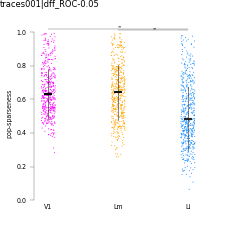

In [31]:
%matplotlib notebook
multi_comp_test='fdr_bh' #'fdr_bh'
bw = True

curr_colors = bw_area_colors if bw else area_colors
plot_params=['pop-sparseness'] #, 'lum_ix']
plot_str = 'byCELL' if plot_cells else 'byFOV'

plotdf = popdf.dropna().copy()
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params)

fig, ax = pl.subplots( figsize=(3,3))

y_loc=1.01
offset=0.01
for ai, metric in enumerate(plot_params):
    sns.stripplot(x='visual_area', y=metric, hue='visual_area', data=plotdf, 
                palette=area_colors, order=visual_areas, size=1, ax=ax, zorder=-10000)
    sns.pointplot(x='visual_area', y=metric, hue='visual_area', data=plotdf, 
                color='k', order=visual_areas, scale=1, ax=ax,
                 markers='_', errwidth=0.5, zorder=10000, ci='sd',
                 estimator=np.median)
    sts = pg.pairwise_ttests(data=plotdf, dv=metric, between='visual_area', 
                  parametric=False, padjust='fdr_bh', effsize='eta-square')
    pplot.annotate_multicomp_by_area(ax, sts, y_loc=y_loc, offset=offset, 
                                     fontsize=4, lw=0.25)
    ax.legend_.remove()
ax.set_ylim([0, 1.03])
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
pl.subplots_adjust(left=0.15, right=0.9)

pplot.label_figure(fig, data_id)

<IPython.core.display.Javascript object>


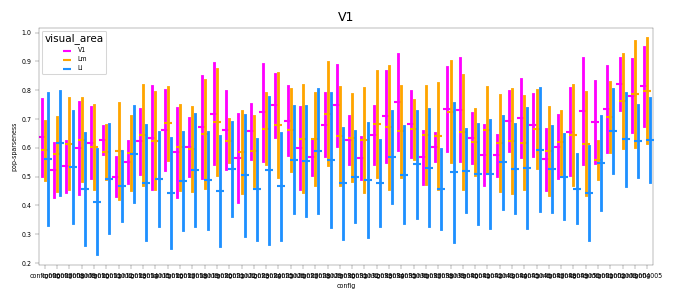

Text(0.5, 1.0, 'V1')

In [32]:
fig, ax = pl.subplots(1, 1, figsize=(9,4), tight_layout=True)

#sns.stripplot(x='config', y='sparseness', data=df_, ax=ax)
sns.pointplot(x='config', y='pop-sparseness', hue='visual_area', data=plotdf, ax=ax,
             join=False, palette=area_colors, markers='_', ci='sd', dodge=0.5,
             hue_order=visual_areas)
ax.set_title(va)

In [35]:
morphlevels = sorted(sdf['morphlevel'].unique())
sizes = sorted(sdf['size'].unique())
n_morphs = len(morphlevels)
n_sizes = len(sizes)

va='V1'
dk='20191006_JC110_fov1'
df_= plotdf[(plotdf.visual_area==va) & (plotdf.datakey==dk)].copy()
cfg_list = sorted(df_.groupby('config')['pop-sparseness'].mean().index.tolist())
morph_arr = sdf.loc[cfg_list]['morphlevel'].values
morph_mat = np.reshape(morph_arr, (n_morphs, n_sizes)).T.astype(float)

size_arr = sdf.loc[cfg_list]['size'].values
size_mat = np.reshape(size_arr, (n_morphs, n_sizes)).T.astype(float)


In [36]:
mat_labels = np.asarray(['(%i, %i)' % (sz, mp) for sz, mp \
                         in sdf[['size', 'morphlevel']].values])\
                        .reshape(n_morphs, n_sizes).T

0.06500146932663164 0.9913679773341899


<IPython.core.display.Javascript object>


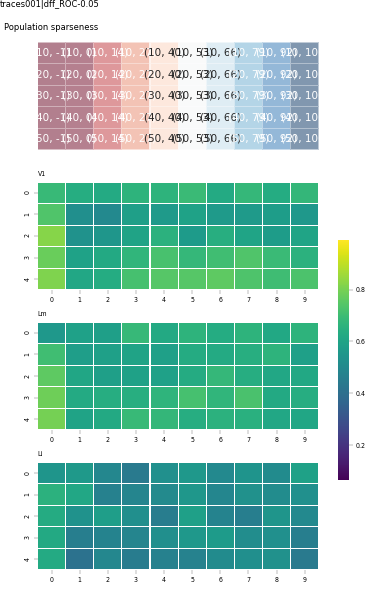

/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


Text(0.01, 0.95, 'Population sparseness')

In [37]:
vmin=plotdf['pop-sparseness'].min()
vmax=plotdf['pop-sparseness'].max()
print(vmin, vmax)
cmap='viridis'

# fig = pl.figure(constrained_layout=True, figsize=(5,8))
# gs1 = fig.add_gridspec(nrows=4, ncols=2, left=0.05, right=0.48,
#                         wspace=0.05)
# ax0 = fig.add_subplot(gs1[0, 0:2])
lw=0.1

fig, axn = pl.subplots(4, 1, constrained_layout=True, figsize=(5,8))

# sns.heatmap(morph_mat, annot=mat_labels, fmt='', ax=ax0)
ax0 = axn[0]
sns.heatmap(morph_mat, annot=mat_labels, fmt='', ax=ax0, cbar=0, cmap='RdBu',
           alpha=0.5, linewidths=lw)
ax0.axis('off')
cbar_ax = fig.add_axes([.9, .2, .03, .4])

for va, df_ in plotdf.groupby('visual_area'):
    ai = visual_areas.index(va)
    ax = axn[ai+1] #fig.add_subplot(gs1[1+ai, 0:])
    
    vals = df_.groupby('config')['pop-sparseness'].mean().values
    resp_mat = np.reshape(vals, (n_morphs, n_sizes)).T.astype(float)
    sns.heatmap(resp_mat, fmt='', ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
               cbar=ai==0, cbar_ax=None if ai else cbar_ax, linewidths=lw)
    ax.set_title(va, loc='left', fontsize=6)
pl.subplots_adjust(left=0.1, top=.93, right=0.85, bottom=0.05, hspace=0.3)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.95, 'Population sparseness', fontsize=8)

In [ ]:
df_.groupby('config')['sparseness'].mean()